<a href="https://colab.research.google.com/github/werew/deep-trading/blob/main/trigger_on_random_walk_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

%pip install wandb
import wandb

from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

project_name = 'trigger_on_random_walk'
project_dir = '/content/drive/MyDrive/Colab Notebooks'

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 180 kB 47.8 MB/s 
     |████████████████████████████████| 140 kB 49.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=2451bef5b850e47cfc7195dd11f99ccc7cc1436c56ee7ecc55f0a6544a7599b6
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=ce741527e3cdb19c92af5651bd9f3686b08c8be7fe75ca7abf629e6fadb5c594
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
Mounted at /content/drive
Using cuda device


# Common

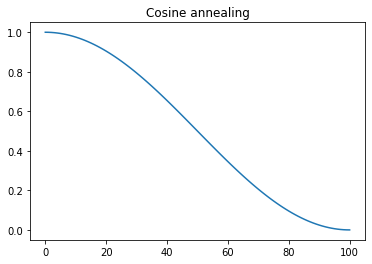

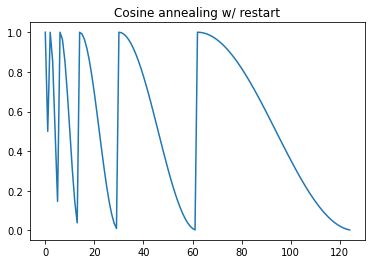

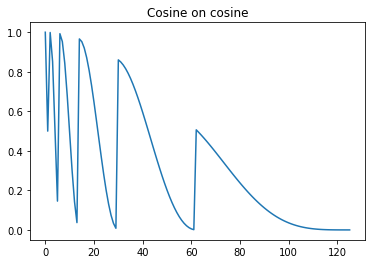

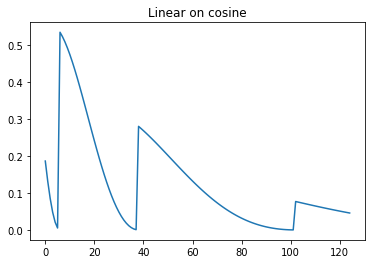

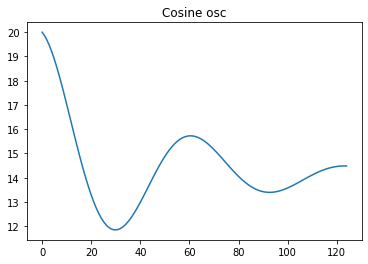

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
def cosine_annealing(start, T_max, eta_min=0, last_epoch=0):
  n_min, n_max = eta_min, start
  T_cur = last_epoch
  while T_cur <= T_max:
    yield ((n_min + (n_max - n_min)) * (1 + math.cos(math.pi * T_cur / T_max))) / 2
    T_cur += 1

plt.title('Cosine annealing')
plt.plot(np.array(list(cosine_annealing(1, 100))))
plt.show()

def cosine_annealing_warm_restars(start, T_0, T_mult=1, eta_min=0, last_epoch=0):
  n_min, n_max = eta_min, start

  if T_mult == 1:
    T_cur = last_epoch % T_0
    T_i = T_0
  else:
    n = int(math.log((last_epoch / T_0 * (T_mult - 1) + 1), T_mult))
    T_cur = last_epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
    T_i = T_0 * T_mult ** n

  while True:
    yield ((n_min + (n_max - n_min)) * (1 + math.cos(math.pi * T_cur / T_i))) / 2

    T_cur += 1
    if T_cur >= T_i:
      T_cur -= T_i
      T_i *= T_mult

    last_epoch += 1

plt.title('Cosine annealing w/ restart')
g = cosine_annealing_warm_restars(1, 1, 2, last_epoch=1)
plt.plot([next(g) for i in range(125)])
plt.show()

def cosine_on_cosine(start, periods, T_0, T_mult=1, eta_min=0, last_epoch=0):
  T_max = int(T_0 * (1 - T_mult ** (periods + 1)) / (1 - T_mult))
  c = cosine_annealing(1, T_max=T_max, last_epoch=last_epoch)
  wr = cosine_annealing_warm_restars(start, T_0, T_mult=T_mult, eta_min=eta_min, last_epoch=last_epoch)
  for _ in range(T_max - last_epoch):
    cy = next(c)
    yield cy * next(wr)


plt.title("Cosine on cosine")
cc = cosine_on_cosine(1, 6, 1, 2, last_epoch=1)
plt.plot(list(cc))
plt.show()

def linear_on_cosine(start, coef, T_0, T_mult=1, eta_min=0, last_epoch=0):
  wr = cosine_annealing_warm_restars(start, T_0, T_mult=T_mult, eta_min=eta_min, last_epoch=last_epoch)
  while True:
    yield next(wr) * (coef ** last_epoch)
    last_epoch += 1


plt.title("Linear on cosine")
lc = linear_on_cosine(1, 0.98, 1, 2, last_epoch=25)
plt.plot([ next(lc) for _ in range(125)])
plt.show()


def cosine_osc(target, upper, lower, last_epoch=0, a=0.98, osc=0.2):
  while True:
    cos = math.cos(last_epoch * osc)
    k = (a ** last_epoch) * cos / 2 + target

    if cos > 0:
      yield k + (a ** last_epoch)*(cos*upper - cos*target)
    else:
      yield k + (a ** last_epoch)*(cos*lower + cos*target)
    last_epoch += 1


def cosine_osc(target, upper, lower, last_epoch=0, annealing_coef=0.98, freq_coef=0.1):
  while True:
    c = math.cos(last_epoch * freq_coef)
    a = (annealing_coef ** last_epoch)

    u = target + (upper - target)*a
    l = target - (target - lower)*a
    k = (a * c * (upper - lower) + u + l) / 2
    yield k
    last_epoch += 1

plt.title("Cosine osc")
g = cosine_osc(14, 20, 10, last_epoch=0)
plt.plot([ next(g) for _ in range(125)])
plt.show()

# Dataset setup


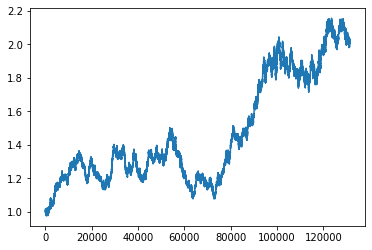

In [ ]:
MEAN_BTC_BUSD_RETURNS = 2.357400880745937e-06
STD_BTC_BUSD_RETURNS = 0.0012172864564457021

# Gaussian random walk
def random_walk(size, start=1, feature_range=(-1,1), mean=MEAN_BTC_BUSD_RETURNS, std=STD_BTC_BUSD_RETURNS):
  # List of step sizes
  returns = torch.normal(mean,std, (size,1))

  # Apply stepsizes starting from `start`
  values = torch.zeros(returns.shape)

  values[0] = start
  for i in range(1,len(values)):
    values[i] = values[i-1]*(1 + returns[i])
  return values

plt.plot(random_walk(365*30*12))

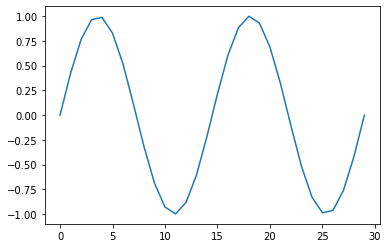

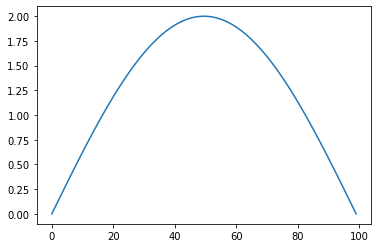

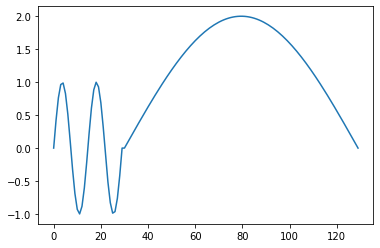

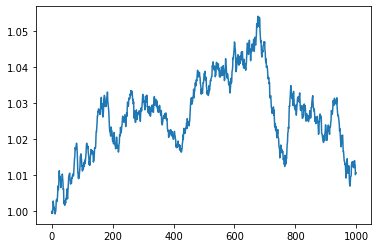

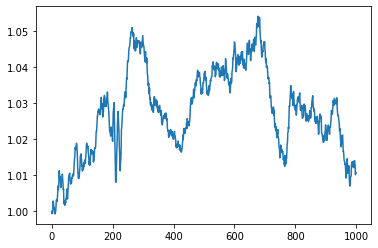

In [ ]:
# Signal that precedes a price raise
trigger = torch.sin(torch.linspace(0,np.pi*2*2, 30)).view(-1,1)
plt.plot(trigger)
plt.show()

# Temporaru price raise
effect = torch.sin(torch.linspace(0,np.pi, 100)).view(-1,1) * 2
plt.plot(effect)
plt.show()

# Full set of events
trigger_effect = torch.cat([trigger,effect])
plt.plot(trigger_effect)
plt.show()

# Example of random walk w/o and w/ trigger-event sequencece
rw = random_walk(1000)
plt.plot(rw)
plt.show()

i = 200
rw[i:i+len(trigger_effect)] += trigger_effect * 0.01
plt.plot(rw)
plt.show()

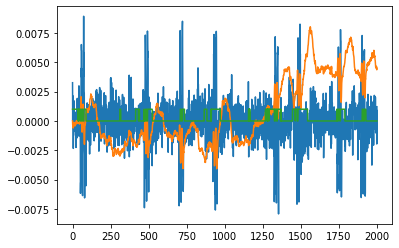

In [ ]:
RETURNS_WINDOW = 60

# Dataset
def gen_dataset(size):
  x = random_walk(size)
  y = torch.zeros((size,1))

  def try_add(tensor, i, values):
    if len(tensor[i:]) <= len(values):
      return False
    tensor[i:i+len(values)] += values
    return True

  def get_label(s):
    if len(s) < 2:
      return 0

    # Relative returns wrt the start
    s = (s[1:] - s[0]) / s[0]

    if s[:RETURNS_WINDOW].max().item() > 0.02:
        return 1
    return 0

  i = 0
  te = trigger_effect * 0.015
  while i < size:
    if random.random() < 0.005:
      try_add(x,i,te)
      i += len(te)
      continue
    i += 1

  i = 0
  win = 200
  while i < size:
    y[i] = get_label(x[i:i+win])
    i += 1

  raw = x
  x = (x / x.roll(-1) - 1)
  return x[:-1], y[:-1], raw[:-1]

def make_or_load_datasets():
  data_path = f'{project_dir}/{project_name}_dataset.pt'
  if os.path.exists(data_path):
    return torch.load(data_path)

  data = {}
  data['train_x'], data['train_y'], data['train_raw'] = gen_dataset(365*24*60)
  data['dev_x'], data['dev_y'], data['dev_raw'] = gen_dataset(int(365*24*60*0.2))
  data['test_x'], data['test_y'], data['test_raw'] = gen_dataset(int(365*24*60*0.2))
  torch.save(data, data_path)
  return data

datasets = make_or_load_datasets()

plt.plot(datasets['train_x'][:2000])
plt.plot((datasets['train_raw'][:2000]-1) * 0.1)
plt.plot(datasets['train_y'][:2000]*0.001)
plt.show()

# Move datasets to selected device
for k, v in datasets.items():
  datasets[k] = v.to(device)

# Training setup

In [ ]:
class Model(nn.Module):

 def __init__(self, input_size):
   super(Model, self).__init__()
   self.size = input_size

   self.cnn_0 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=8, padding='same')
   self.bn_0 = nn.BatchNorm1d(num_features=64)
   self.lrelu_0 = nn.LeakyReLU()

   self.cnn_1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding='same')
   self.bn_1 = nn.BatchNorm1d(num_features=128)
   self.lrelu_1 = nn.LeakyReLU()

   self.cnn_2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
   self.bn_2 = nn.BatchNorm1d(num_features=64)
   self.lrelu_2 = nn.LeakyReLU()

   self.avgp_3 = nn.AvgPool1d(5)
   self.flatten_3 = nn.Flatten()
   self.linear_3 = nn.Linear(in_features=int(self.size / 5 * 64), out_features=1)


 def forward(self, x):

   x = self.cnn_0(x)
   x = self.bn_0(x)
   x = self.lrelu_0(x)

   x = self.cnn_1(x)
   x = self.bn_1(x)
   x = self.lrelu_1(x)

   x = self.cnn_2(x)
   x = self.bn_2(x)
   x = self.lrelu_2(x)

   x = self.avgp_3(x)
   x = self.flatten_3(x)
   x = self.linear_3(x)

   return x

def load_model(version, size):
  model = Model(size)
  model_path = f'{project_dir}/{project_name}_model_{version}.pt'
  model.load_state_dict(torch.load(model_path))
  return model

def save_model(model, version):
  model_path = f'{project_dir}/{project_name}_model_{version}.pt'
  torch.save(model.state_dict(), model_path)

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, x, y, raw, seq_len):
    self.x = x
    self.y = y
    self.raw = raw
    self.seq_len = seq_len
    if self.__len__() < 1:
      raise ValueError("Input too short")

  def __len__(self):
    return self.x.shape[0] - self.seq_len

  def __getitem__(self, index):
    x = self.x[index: index+self.seq_len]
    y = self.y[index: index+self.seq_len]
    return (x, y)

In [ ]:
def get_trading_results(params, preds, prices):
  t = params['hyperparams']['threshold']
  position = None
  invested = []
  returns = []
  pct_change = lambda a,b: (b-a) / a

  for i, (price, pred) in enumerate(zip(prices.view(-1), preds)):
    price, pred = price.item(), pred.item()
    invested.append(position is not None)

    if pred > t:
      if position is None:
        position = {'i':i, 'price':price} # Buy
      else:
        position['i'] = i # Update for timeout
      continue

    if position is None:
      continue

    roi = pct_change(position['price'], price)
    if roi >= 0.2 or roi <= -0.1 or i > position['i'] + RETURNS_WINDOW*2:
      position = None
      returns.append(roi)

  returns = torch.tensor(returns)
  return {
      'number_returns': len(returns),
      'total_returns': returns.sum().item(),
      'std_returns': returns.std().item(),
      'mean_returns': returns.mean().item(),
      'median_returns': returns.median().item(),
      'invested': torch.tensor(invested),
  }

def get_metrics(pred, y, threshold):
    t = threshold
    return {
      'tp': ((pred > t) & (y == 1.)).sum().item(),
      'fp': ((pred > t) & (y == 0.)).sum().item(),
      'tn': ((pred <= t) & (y == 0.)).sum().item(),
      'fn': ((pred <= t) & (y == 1.)).sum().item(),
    }

def get_precision_recall(res):
  e = 0.0000000000001
  return {
    f'precision': (
        res['tp'] / (res['tp'] + res['fp'] + e)
    ),
    f'recall': (
        res['tp'] / (res['tp'] + res['fn'] + e)
    ),
  }

def _loop(params, dataloader, backprop=False):
    num_batches = len(dataloader)
    res = defaultdict(int)

    for batch, (x, y) in enumerate(dataloader):

        # Input shape: (batch_size, seq_len, 1) -> (batch_size, 1, seq_len)
        x = x.view(-1, 1, params['model'].size)

        # Labels shape: (batch_size, seq_len, 1) -> (batch_size, 1)
        # the label is the last one
        y = y[:,-1:].view(-1,1)

        # Compute prediction and loss
        pred = params['model'](x)
        loss = params['loss_fn'](pred, y)

        # Backpropagation
        if backprop:
          params['optimizer'].zero_grad()
          loss.backward()
          params['optimizer'].step()

        # Add up loss
        res['loss'] += loss.item()

        # Get metrics
        pred = torch.sigmoid(pred)
        threshold = params['hyperparams']['threshold']
        for k,v in get_metrics(pred=pred, y=y, threshold=threshold).items():
          res[k] += v

        if batch % 500 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{num_batches:>5d}]")

    res['loss'] /= num_batches
    res.update(get_precision_recall(res))

    return res

def train_loop(params, dataloader):
    return _loop(params, dataloader, backprop=True)

def test_loop(params, dataset):
    # Dataloader only needed to avoid loading the data all at once
    dataloader = DataLoader(dataset, batch_size=params['hyperparams']['batch_size'], shuffle=False)

    with torch.no_grad():
      return _loop(params, dataloader, backprop=False)

In [ ]:
# We start at epoch zero
epoch = 0

# Init W&B run
wandb_run = wandb.init(project=project_name)

# Load model
MODEL_SIZE = 100
#model = load_model('hardy-yogurt-12', MODEL_SIZE)
model = Model(input_size=MODEL_SIZE)
model.to(device)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Model(
  (cnn_0): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=same)
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu_0): LeakyReLU(negative_slope=0.01)
  (cnn_1): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=same)
  (bn_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu_1): LeakyReLU(negative_slope=0.01)
  (cnn_2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=same)
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu_2): LeakyReLU(negative_slope=0.01)
  (avgp_3): AvgPool1d(kernel_size=(5,), stride=(5,), padding=(0,))
  (flatten_3): Flatten(start_dim=1, end_dim=-1)
  (linear_3): Linear(in_features=1280, out_features=1, bias=True)
)

In [ ]:

pos = datasets['train_y'].sum().item()
neg = datasets['train_y'].nelement() - pos

# Hyperparams
hyperparams = {
  'learning_rate': 0.00001,
  'batch_size': 64,
  'pos_weight': (neg / pos) * 1.,
  'threshold': 0.5,
}

params = {
  'hyperparams': hyperparams,
  'loss_fn': nn.BCEWithLogitsLoss(pos_weight=torch.tensor([hyperparams['pos_weight']]).to(device)),
  'optimizer': torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate']),
  'model': model,
}


# Training

In [ ]:
#params['hyperparams']['learning_rate'] = 0.0001
params['hyperparams']['learning_rate'] = 0.0001

In [ ]:
seq_len = params["model"].size
training_data = TimeSeriesDataset(datasets['train_x'], datasets['train_y'], datasets['train_raw'], seq_len)
train_dataloader = DataLoader(training_data, batch_size=hyperparams['batch_size'], shuffle=True)

testing_data = TimeSeriesDataset(datasets['dev_x'], datasets['dev_y'], datasets['dev_raw'], seq_len)

# Training
for _ in range(10):
  epoch += 1
  print(f"Epoch {epoch}\n-------------------------------")

  # Train
  train_res = train_loop(params, train_dataloader)

  # Test
  test_res = test_loop(params, testing_data)

  # Show some data
  print(
      f"\nTrain loss: {train_res['loss']}\n"
      f"Test loss: {test_res['loss']}\n"
      f"Test precision: {test_res['precision']}\n"
      f"Test recall: {test_res['recall']}\n"
  )

  # Log results
  wandb_run.log({
    'epoch': epoch,
    'seq_len': seq_len,
    'train': train_res,
    'test': test_res,
    **hyperparams,
  })

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


loss: 1.520577  [    0/ 8211]
loss: 1.030175  [  500/ 8211]
loss: 1.186877  [ 1000/ 8211]
loss: 0.696294  [ 1500/ 8211]
loss: 0.881957  [ 2000/ 8211]
loss: 0.720609  [ 2500/ 8211]
loss: 0.587256  [ 3000/ 8211]
loss: 0.779699  [ 3500/ 8211]
loss: 0.693403  [ 4000/ 8211]
loss: 1.082077  [ 4500/ 8211]
loss: 0.561241  [ 5000/ 8211]
loss: 1.009835  [ 5500/ 8211]
loss: 0.662346  [ 6000/ 8211]
loss: 1.302035  [ 6500/ 8211]
loss: 1.134465  [ 7000/ 8211]
loss: 0.705988  [ 7500/ 8211]
loss: 0.876840  [ 8000/ 8211]
loss: 0.083973  [    0/ 1641]
loss: 0.302955  [  500/ 1641]
loss: 1.027144  [ 1000/ 1641]
loss: 0.341087  [ 1500/ 1641]

Train loss: 0.8790899569958344
Test loss: 1.165715511236737
Test precision: 0.6491871214536181
Test recall: 0.5862681124652145

Epoch 2
-------------------------------
loss: 1.023521  [    0/ 8211]
loss: 0.630875  [  500/ 8211]
loss: 0.915279  [ 1000/ 8211]
loss: 0.665053  [ 1500/ 8211]
loss: 1.016347  [ 2000/ 8211]
loss: 0.692552  [ 2500/ 8211]
loss: 1.220128  [ 300

# Testing

In [ ]:
def get_preds(dataset):
  with torch.no_grad():
    tmp = []
    for i in range(len(dataset)):
      x,y = dataset[i]
      # Input shape: (batch_size, seq_len, 1) -> (batch_size, seq_len)
      x = x.view(-1, params['model'].size)

      # Labels shape: (batch_size, seq_len, 1) -> (batch_size, 1)
      # the label is the last one
      y = y[:,-1:].view(-1,1)

      tmp.append(params['model'](x))

    pred_raw = torch.tensor(tmp)

    return {
        'pred_raw': pred_raw,
        'pred': torch.sigmoid(pred_raw),
    }

In [ ]:
dev_data = TimeSeriesDataset(datasets['dev_x'], datasets['dev_y'], datasets['dev_raw'], model.size)
test_loop(params, dev_data)

loss: 0.004246  [    0/ 1641]
loss: 0.090426  [  500/ 1641]
loss: 0.000780  [ 1000/ 1641]
loss: 0.008503  [ 1500/ 1641]


defaultdict(int,
            {'fn': 16577,
             'fp': 41,
             'loss': 0.05304709174383675,
             'precision': 0.9904784022294473,
             'recall': 0.20463487189329238,
             'tn': 84108,
             'tp': 4265})

In [ ]:
dev_pred = get_preds(dev_data)
dev_trading = get_trading_results(params, dev_pred['pred'], dev_data.raw[model.size:])
dev_trading

{'invested': tensor([False, False, False,  ..., False, False, False]),
 'mean_returns': 0.013902507722377777,
 'median_returns': 0.013617287389934063,
 'number_returns': 311,
 'std_returns': 0.015124247409403324,
 'total_returns': 4.3236799240112305}

In [ ]:
test_data = TimeSeriesDataset(datasets['test_x'], datasets['test_y'], datasets['test_raw'], model.size)
test_loop(params, test_data)

loss: 0.013421  [    0/ 1641]
loss: 0.002109  [  500/ 1641]
loss: 0.000547  [ 1000/ 1641]
loss: 0.005644  [ 1500/ 1641]


defaultdict(int,
            {'fn': 16208,
             'fp': 49,
             'loss': 0.05179127815079073,
             'precision': 0.9855329199881901,
             'recall': 0.1707766294894096,
             'tn': 85396,
             'tp': 3338})

In [ ]:
test_pred = get_preds(test_data)
test_trading = get_trading_results(params, test_pred['pred'], test_data.raw[model.size:])
test_trading

{'invested': tensor([False, False, False,  ..., False, False, False]),
 'mean_returns': 0.013763603754341602,
 'median_returns': 0.013759600929915905,
 'number_returns': 309,
 'std_returns': 0.01658366061747074,
 'total_returns': 4.25295352935791}

In [ ]:
save_model(model, wandb_run.name)

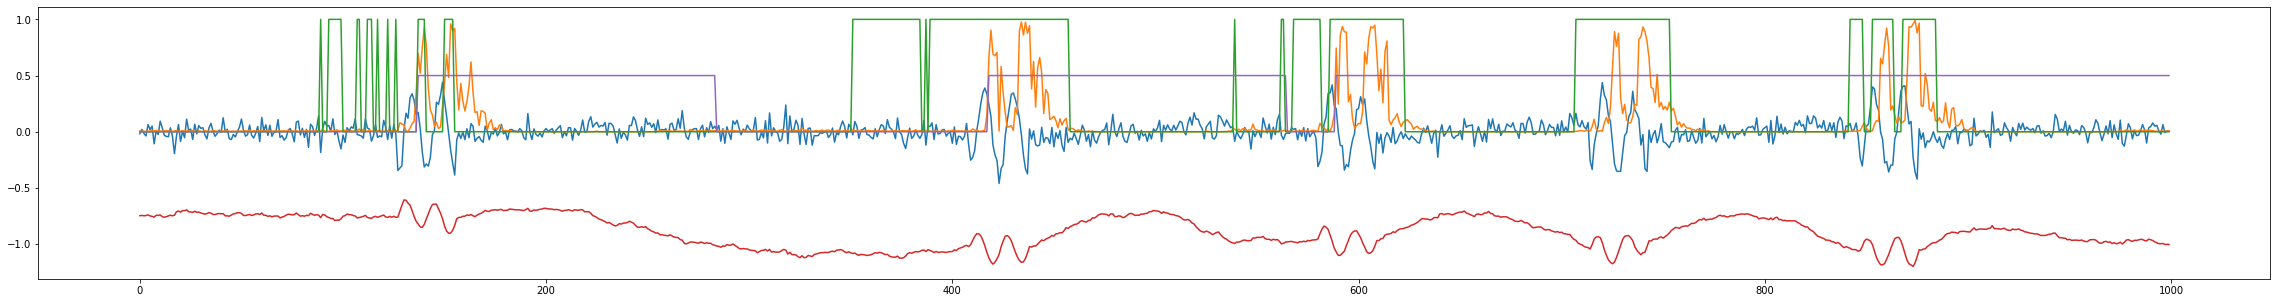

In [ ]:
plt.rcParams['figure.figsize'] = [40, 5]
w = 1000
s = w*3
e = s+w
plt.plot(datasets['test_x'][s:e].cpu()*50)
#plt.plot((test_pred['pred'][s-model.size:e-model.size] ).cpu() )
plt.plot((test_pred['pred'][s-model.size:e-model.size] ).cpu() )
plt.plot((datasets['test_y'][s:e]).cpu())
plt.plot((datasets['test_raw'][s:e]*8 - 8.495).cpu())
plt.plot(test_trading['invested'][s+1-model.size:e+1-model.size]*0.5)
plt.show()

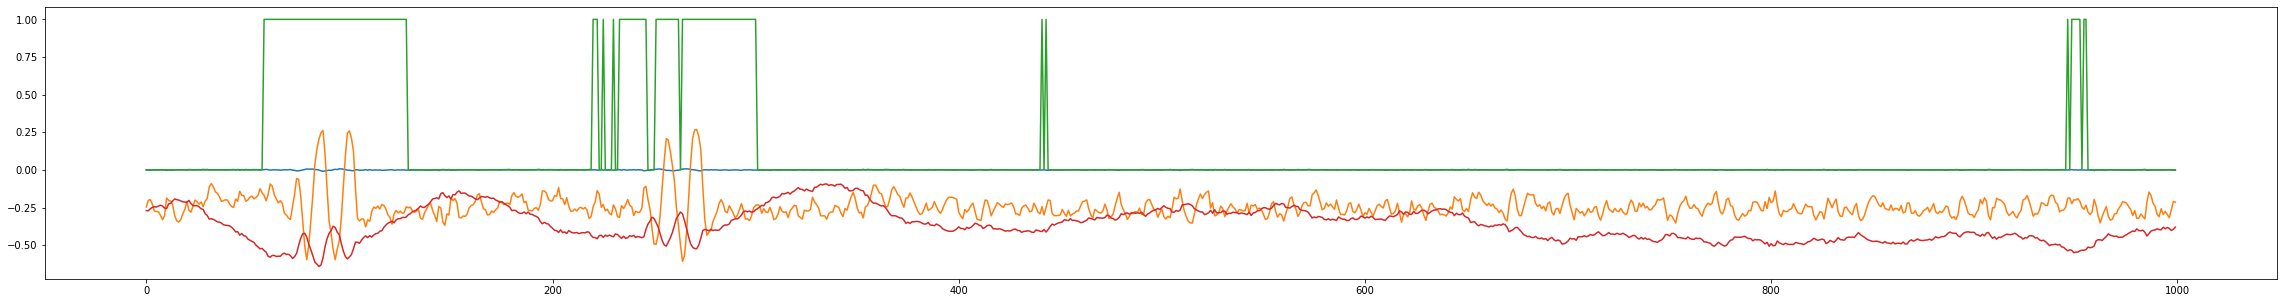

In [ ]:
plt.rcParams['figure.figsize'] = [40, 5]
w = 1000
s = w*51
e = s+w
plt.plot(datasets['dev_x'][s:e].cpu())
plt.plot((pred[0][s:e]*2000-1000).cpu() )
plt.plot((datasets['dev_y'][s:e]).cpu())
plt.plot((datasets['dev_raw'][s:e]*8 - 8.495).cpu())
plt.show()

In [ ]:
(pred > 0.985).sum()

tensor(122, device='cuda:0')

TODO
- try on more difficult dataset
  - add gaussian noise to the data
  - randomly remove some datapoints
- positive weight annealing at each epoch
  - reference weight is w = neg/pos, actual weight is w*c where c is a dynamic coefficient  
  - start with an high coef (e.g. 1.3): force the net into learning positive sequences
  - slowly decrease the coef (e.g. to 0.1): reduce false positives at the cost of false negatives
  - (maybe) slowly increase again (e.g. the coef could be oscilating)
- add learnig rate decay (https://stackoverflow.com/questions/39517431/should-we-do-learning-rate-decay-for-adam-optimizer)
- use a dataset closer to the trading data (longer series of 1s)